# Density charge and density spin evolution over time

Author: Javier Norambuena Leiva — Posted: . Last updated: .

Here we discuss how to calculate the spin and charge density of the ground state of a molecule. This state is evolved over time to see how this density change over it.

In [1]:
from pennylane import numpy as np
import pennylane as qml
from pennylane.templates import ApproxTimeEvolution
import matplotlib.pyplot as plt
import scipy as sc

## Hamiltonian build

Here we use the construction of the hamiltonian of $H^{2}$ that it indicated in the [Building Hamiltonian Demo](https://pennylane.ai/qml/demos/tutorial_quantum_chemistry.html).

In [2]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
Hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

In [3]:
coeff, expression = Hamiltonian.terms()
Pauli_terms = []

for k, term in enumerate(expression):
    auxiliar_string =[]
    if type(term)==qml.ops.qubit.non_parametric_ops.PauliZ:
        index = term.wires[0]
        for j in range(qubits):
            if j== index:
                auxiliar_string.append("Z")
            else:
                auxiliar_string.append("I")
    
    elif type(term)==qml.ops.qubit.non_parametric_ops.PauliX:
        index = term.wires[0]
        for j in range(qubits):
            if j== index:
                auxiliar_string.append("X")
            else:
                auxiliar_string.append("I")
    
    elif type(term)==qml.ops.qubit.non_parametric_ops.PauliY:
        index = term.wires[0]
        for j in range(qubits):
            if j== index:
                auxiliar_string.append("Y")
            else:
                auxiliar_string.append("I")

    elif type(term)==qml.ops.identity.Identity:
        for j in range(qubits):
            auxiliar_string.append("I")
    
    else:
        Nonidentical = term.non_identity_obs
        auxiliar_string = ["I" for _ in range(qubits)]
        for pauli in Nonidentical:
            index = pauli.wires[0]
            if type(pauli)==qml.ops.qubit.non_parametric_ops.PauliZ:
                auxiliar_string[index] = "Z"
            elif type(pauli)==qml.ops.qubit.non_parametric_ops.PauliX:
                auxiliar_string[index] = "X"
            elif type(pauli)==qml.ops.qubit.non_parametric_ops.PauliY:
                auxiliar_string[index] = "Y"
            else:
                pass
    string = ""
    for s in auxiliar_string:
        string+= s
    Pauli_terms.append([coeff[k],string])

del Hamiltonian, coeff, expression

In [4]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
singles, doubles = qml.qchem.excitations(electrons, qubits)

dev = qml.device("default.qubit", wires=qubits)
        

The ansatz use the given rotations with singles and double excitations gates to keep the number of electrons fixed. 

In [5]:
@qml.qnode(dev, interface="autograd")
def circuit(param, wires, obs, index):
    qml.BasisState(hf, wires=wires)

    for _, term in enumerate(singles):
        qml.SingleExcitation(param[0], wires=term)

    for _, term in enumerate(doubles):
        qml.DoubleExcitation(param[1], wires=term)

    for i,term in enumerate(obs):
        if term=='X':
            qml.Hadamard(i)
        elif term=='Y':
            qml.S(i)
            qml.Hadamard(i)

    return qml.probs(wires=index)



In [6]:
def is_identity(term):
    for i in range(len(term)):
        if term[i]!='I':
            return False
    return True

def parity(integer):
    binary = format(integer, 'b')
    aux = 0
    for s in binary:
        if s=='1':
            aux +=1
    if aux%2 == 0:
        return 1
    else:
        return -1

def cost_fn(param):
    result = 0.0
    for term in Pauli_terms:
        aux = []
        term[0]
        for i in range( len(term[1]) ):
            if term[1][i] != 'I':
                aux.append(i)  

        if len(aux)==0:
            aux = term[0]
            aux.requires_grad = True
            result += aux 
        else:
            probs = circuit(param, wires=range(qubits), obs=term[1], index=aux)
            for integer in range(len(probs)):
                aux = term[0]
                aux.requires_grad = True
                result += aux*parity(integer)*probs[integer]
    return result

## Ground state calculation

The idea is the evolution of the ground state, so, the first thing is find it. We know that the VQE construct the state inside the circuit so, we just need to find the minimun energy value and with the parameters, we will be able to reconstruct the state inside the circuit. Here we use the gradient minimization method used in [A brief overview of VQE](https://pennylane.ai/qml/demos/tutorial_vqe.html) with the same values, because its the same molecule.

In [7]:
def scipy_method_VQE(cost_function, theta):
    energy = []
    theta_evol = []

    def cost_aux(x): 
        result = cost_function(x)
        energy.append(result)
        theta_evol.append(x)
        return result
    
    theta = sc.optimize.minimize(cost_aux, theta, method='SLSQP', tol=1e-6,
            options= {'maxiter':1000})['x']
    return energy, theta_evol, theta

energy, theta_evol, theta = scipy_method_VQE(cost_fn, [0.0, 0.0])

In [8]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)
theta = np.array([0.0, 0.0], requires_grad=True)

In [9]:
energy = [cost_fn(theta)]
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)
    if conv <= conv_tol:
        break



## Time evolution of the ground state

With the paramaters that will help us to construct the ground state, the next step is introduce the time evolution operator in the circuit. 

Here we use the [qml.ApproxTimeEvolution](https://docs.pennylane.ai/en/stable/code/api/pennylane.ApproxTimeEvolution.html#pennylane.ApproxTimeEvolution) module of pennylane, that implement the time evolution operator for any hamiltonian that can be expressed as a product of Pauli matrices.



In [10]:
@qml.qnode(dev, interface="autograd")
def cost_fn_time(theta, obs, time, n, hamiltonian):
    '''Ground state'''
    qml.BasisState(hf, wires=range(qubits))
    for j, term in enumerate(singles):
        qml.SingleExcitation(theta[0], wires=term)

    for j, term in enumerate(doubles):
        qml.DoubleExcitation(theta[1], wires=term)

    '''Time evolution'''
    for _ in range(n):
        for coeff, term in hamiltonian:
            if is_identity(term):
                pass
            else:
                non_null_index = []
                for k in range(len(term)):
                    if term[k] != 'I':
                        non_null_index.append(k)

                '''Initial basis change'''
                for k in range(len(non_null_index)):
                    if term[k] == 'X':
                        qml.Hadamard(wires=[non_null_index[k]])
                    elif term[k] == 'Y':
                        qml.S(wires=[non_null_index[k]])
                        qml.Hadamard(wires=[non_null_index[k]])
                    else:
                        pass
                '''Initial CX gates'''
                for k in range(len(non_null_index)-1):
                    qml.CNOT(wires=[non_null_index[k], non_null_index[k+1]])

                '''Time parameter'''
                qml.RZ( (2*time/n)*coeff, non_null_index[-1] )

                '''Final CX gates'''
                for k in range(len(non_null_index)-1):
                    qml.CNOT(wires=[non_null_index[k], non_null_index[k+1]])
                    
                '''Final basis change'''
                for k in range(len(non_null_index)):
                    if term[k] == 'X':
                        qml.Hadamard(wires=[non_null_index[k]])
                    elif term[k] == 'Y':
                        qml.Hadamard(wires=[non_null_index[k]])
                        qml.S(wires=[non_null_index[k]])
                    else:
                        pass
    return qml.probs(wires=obs[0]), qml.probs(wires=obs[1])

## Densities calculation
At this point we have all the requirement elements, the time evolution and the ground state. So, the next thing to see is how to calculate the density with the proyections.

In reference 1, they define the density of each site in a hubbard model as $\rho^{\pm} = \langle n_{i,\uparrow} \rangle \pm \langle n_{i,\downarrow} \rangle$, where the terms are the particle number operator in each site for each type of spin orientation. The important thing is this operator have a expresion in the spin space as $n_{i} = |1\rangle \langle 1|_i$.

If we divide the array the qubits into a block of two consecutive qubits, we can consider each pair as site that can be ocupate by a electron of spin up and one of spin down. 

Let take an example, let say that we have one site and we have two qubits, one to represent the electron with spin up ($Q1$) and another for the spin down ($Q2$), if we want to compute $\langle n_{i,\uparrow} \rangle$ we need to measure $Q1$ (because, is the qubit that represent that configuration of index).

In the following code, we compute the density in each time step to how evolve in time with a time step of $0.2$.

In [11]:
number_pairs = int( qubits/2 )
charge_density = []
spin_density = []
delta_time = 0.2
time_steps = 200
n=7


for t in range(time_steps):
    aux_charge = []
    aux_spin = []
    for i in range(number_pairs):
        result_down, result_up = cost_fn_time(theta, obs =[2*i, 2*i+1], time=t*delta_time, n=n, hamiltonian=Pauli_terms)
        #result_up = cost_fn_time(theta, obs =[2*i+1], time=t*delta_time)
        aux_charge.append(result_up[1] + result_down[1])
        aux_spin.append(result_up[1] - result_down[1])
    charge_density.append( aux_charge )
    spin_density.append( aux_spin )

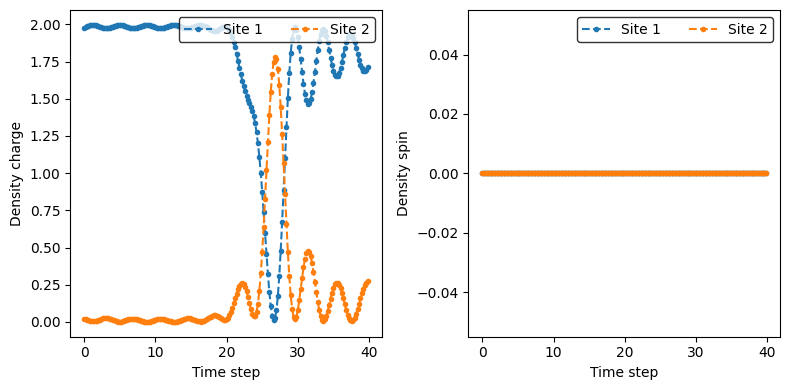

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].plot([i*delta_time for i in range(time_steps)], [j[0] for j in charge_density], ".", label="Site 1", ls="dashed")
ax[0].plot([i*delta_time for i in range(time_steps)], [j[1] for j in charge_density], ".", label="Site 2", ls="dashed")
ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k',ncol=2)

ax[1].plot([i*delta_time for i in range(time_steps)], [j[0] for j in spin_density], ".", label="Site 1", ls="dashed")
ax[1].plot([i*delta_time for i in range(time_steps)], [j[1] for j in spin_density], ".", label="Site 2", ls="dashed")
ax[1].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k',ncol=2)

ax[0].set_xlabel('Time step', fontsize=10)
ax[1].set_xlabel('Time step', fontsize=10)

ax[0].set_ylabel('Density charge', fontsize=10)
ax[1].set_ylabel('Density spin', fontsize=10)
fig.tight_layout()
plt.show()

## References
1. Frank Arute, Kunal Arya, Ryan Babbush, Dave Bacon, Joseph C. Bardin, Rami Barends, Andreas Bengtsson, Sergio Boixo, Michael Broughton, Bob B. Buckley, David A. Buell, Brian Burkett, Nicholas Bushnell, Yu Chen, Zĳun Chen, Yu-An Chen, Ben Chiaro, Roberto Collins, Stephen J. Cotton, William Courtney, Sean Demura, Alan Derk, Andrew Dunsworth, Daniel Eppens, Thomas Eckl, Catherine Erickson, Edward Farhi, Austin Fowler, Brooks Foxen, Craig Gidney, Marissa Giustina, Rob Graff, Jonathan A. Gross, Steve Habegger, Matthew P. Harrigan, Alan Ho, Sabrina Hong, Trent Huang, William Huggins, Lev B. Ioffe, Sergei V. Isakov, Evan Jeffrey, Zhang Jiang, Cody Jones, Dvir Kafri, Kostyantyn Kechedzhi, Julian Kelly, Seon Kim, Paul V. Klimov, Alexander N. Korotkov, Fedor Kostritsa, David Landhuis, Pavel Laptev, Mike Lindmark, Erik Lucero, Michael Marthaler, Orion Martin, John M. Martinis, Anika Marusczyk, Sam McArdle, Jarrod R. McClean, Trevor McCourt, Matt McEwen, Anthony Megrant, Carlos Mejuto-Zaera, Xiao Mi, Masoud Mohseni, Wojciech Mruczkiewicz, Josh Mutus, Ofer Naaman, Matthew Neeley, Charles Neill, Hartmut Neven, Michael Newman, Murphy Yuezhen Niu, Thomas E. O'Brien, Eric Ostby, Bálint Pató, Andre Petukhov, Harald Putterman, Chris Quintana, Jan-Michael Reiner, Pedram Roushan, Nicholas C. Rubin, Daniel Sank, Kevin J. Satzinger, Vadim Smelyanskiy, Doug Strain, Kevin J. Sung, Peter Schmitteckert, Marco Szalay, Norm M. Tubman, Amit Vainsencher, Theodore White, Nicolas Vogt, Z. Jamie Yao, Ping Yeh, Adam Zalcman, & Sebastian Zanker. (2020). Observation of separated dynamics of charge and spin in the Fermi-Hubbard model.

